In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model 
import io
import base64
from IPython.display import HTML
import cv2
import zipfile

https://www.kaggle.com/deadskull7/fer2013



In [0]:
zip_file = zipfile.ZipFile('fer2013.zip')
zip_file.extractall('input')
zip_file.close()

#### Read and Prepare data

In [3]:
data = pd.read_csv("input/fer2013.csv")
data.pixels = data.pixels.str.split()
data.head()

,emotion,pixels,Usage
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",Training
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",Training
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",Training
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",Training
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",Training


In [4]:
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [5]:
data.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [0]:
img_size = 48
emotion_to_str = {0:"ANGRY", 1:"DISGUST", 2:"FEAR", 3:"HAPPY", 4:"SAD", 5:"SURPRISE", 6:"NEUTRAL"}

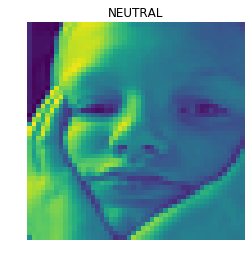

In [7]:
idx = 601
row = data.iloc[idx]
img = np.array(row.pixels, dtype=np.int)
img = img.reshape(img_size, img_size)
plt.title(emotion_to_str[row.emotion])
plt.imshow(img)
plt.axis("off")
plt.show()

In [0]:
def process_dataframe_images(images):
    images = np.array(list(images), dtype=np.int)
    images = images.reshape(-1,img_size, img_size,1)
    return images

def images_to_data(images):
    images = images/255.
    return images

def data_to_images(imgdata):
    imgdata = np.int(255.*imgdata)
    imgdata[imgdata > 255] = 255
    imgdata[imgdata < 0] = 0
    return imgdata

In [9]:
training_data = data[data.Usage == "Training"][["emotion", "pixels"]]
print("Training Dataset:", len(training_data))
training_targets = training_data.emotion.values
training_images = process_dataframe_images(training_data.pixels.values)
training_images = images_to_data(training_images)

PrivateTest_data = data[data.Usage == "PrivateTest"][["emotion", "pixels"]]
print("PrivateTest Dataset:", len(PrivateTest_data))
PrivateTest_targets = PrivateTest_data.emotion.values
PrivateTest_images = process_dataframe_images(PrivateTest_data.pixels.values)
PrivateTest_images = images_to_data(PrivateTest_images)

PublicTest_data = data[data.Usage == "PublicTest"][["emotion", "pixels"]]
print("PublicTest Dataset:", len(PublicTest_data))
PublicTest_targets = PublicTest_data.emotion.values
PublicTest_images = process_dataframe_images(PublicTest_data.pixels.values)
PublicTest_images = images_to_data(PublicTest_images)


Training Dataset: 28709
PrivateTest Dataset: 3589
PublicTest Dataset: 3589


#### Create and Fit Model

In [0]:
def getModel():
    model = tf.keras.Sequential()

    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', 
                     input_shape=(img_size, img_size, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(2*2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2*2*num_features, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2*num_features, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_labels, activation='softmax'))
    return model

In [14]:
K.clear_session()

num_labels = len(emotion_to_str)
num_features = 32
epochs = 1
batch_size = 128

model = getModel()
model.summary()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 64)        2

In [15]:
filepath="weights/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit(training_images, training_targets, 
          epochs=epochs, batch_size=batch_size,
          validation_data=(PrivateTest_images, PrivateTest_targets),
          shuffle=True, callbacks=callbacks_list)

Train on 28709 samples, validate on 3589 samples
28672/28709 [============================>.] - ETA: 0s - loss: 2.0447 - acc: 0.1994
Epoch 00001: val_acc improved from -inf to 0.24492, saving model to weights/weights.best.hdf5
28709/28709 [==============================] - 719s 25ms/sample - loss: 2.0444 - acc: 0.1994 - val_loss: 1.8545 - val_acc: 0.2449


In [16]:
loss, acc = model.evaluate(PublicTest_images, PublicTest_targets, verbose=0)
print("Public Test: \nLoss:", loss, "\nAccuracy:",acc)

Public Test: 
Loss: 1.851476667385043 
Accuracy: 0.24937308


#### Test on Image

In [17]:
model = load_model('content/model.h5')
model.load_weights("content/weights.best.hdf5")

W0724 21:00:33.039867 140491819763584 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0724 21:00:33.045037 140491819763584 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0724 21:00:33.078492 140491819763584 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecat

In [18]:
loss, acc = model.evaluate(PublicTest_images, PublicTest_targets, verbose=0)
print("Public Test: \nLoss:", loss, "\nAccuracy:",acc)

loss, acc = model.evaluate(PrivateTest_images, PrivateTest_targets, verbose=0)
print("Private Test: \nLoss:", loss, "\nAccuracy:",acc)

Public Test: 
Loss: 1.130327940983638 
Accuracy: 0.5826135
Private Test: 
Loss: 1.098867057624651 
Accuracy: 0.5842853


(438, 780, 3)


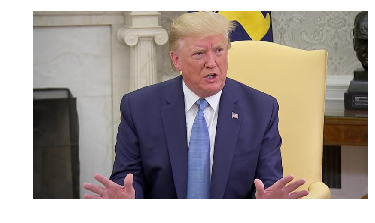

In [19]:
img = cv2.imread('content/TestImage.jpg')
b,g,r = cv2.split(img)           
img_rgb = cv2.merge([r,g,b])

print(img_rgb.shape)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [0]:
face_cascade = cv2.CascadeClassifier('content/haar.xml')

def detect_image_emotion(img):
  grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(grayImg,1.3,5)

  imgcopy = img.copy()

  for (x,y,w,h) in faces: 

    facearray_gray = grayImg[y:y+h, x:x+w]

    width_original = facearray_gray.shape[1]   
    height_original = facearray_gray.shape[0]  

    faceimg_gray = cv2.resize(facearray_gray, (img_size, img_size))   
    faceimg_gray = faceimg_gray/255.

    faceimg_model = np.reshape(faceimg_gray, (1,img_size,img_size,1)) 
    keypoints = model.predict(faceimg_model)[0]

    rectangle_bgr = (0, 0, 255)
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (x,y)
    fontScale              = 0.7
    fontColor              = (0,0,0)
    thickness               = 2

    text = emotion_to_str[np.argmax(keypoints)]
    (text_width, text_height) = cv2.getTextSize(text, font, fontScale=fontScale, thickness=thickness)[0]
    text_offset_x = x
    text_offset_y = y
    box_coords = ((text_offset_x, text_offset_y), 
                  (text_offset_x + text_width, text_offset_y - text_height ))

    cv2.rectangle(imgcopy,(x,y),(x+h,y+w),rectangle_bgr,5)
    cv2.rectangle(imgcopy, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
    cv2.putText(imgcopy, text, (text_offset_x, text_offset_y), font, 
                fontScale=fontScale, color=fontColor, thickness=thickness)

  return imgcopy

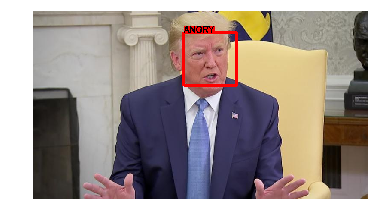

In [21]:
img = cv2.imread('content/TestImage.jpg')
imgcopy = detect_image_emotion(img)
b,g,r = cv2.split(imgcopy)           
img_rgb = cv2.merge([r,g,b])

plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [0]:
cap = cv2.VideoCapture('content/TestVideo3.mp4')

ret, frame = cap.read()
video_shape = (int(cap.get(3)), int(cap.get(4)))

fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
out = cv2.VideoWriter('content/output.mp4',fourcc, 20.0, video_shape, True)

while ret:
  predict_image = detect_image_emotion(frame)
  out.write(predict_image)
  ret, frame = cap.read()

cap.release()
out.release()
cv2.destroyAllWindows()